<a href="https://colab.research.google.com/github/michalis0/DataMining_and_MachineLearning/blob/master/week13/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining and Machine Learning - Week 13
# Clustering

This is an unsupervised learning algorithm (i.e., we have unlabelled data). The objectives of clustering are:
* to organise the data into classes so that there is a high degree of intra-class similarity and a low degree of inter-class similarity
* to find the class labels and the number of classes
directly from the data (in contrast to
classification where the algortihm learned used labelled data).
* to find natural groupings between objects.

There are two types of clustering:
* Partitioning algorithms (for example, k-means)
* Hierarchical clustering

In this lab session we implement and compare them.

### Table of Contents
#### 1. Basic Examples
* 1.1 k-means in 1 dimension
* 1.2 Hierarchical clustering

#### 2. Runtime complexity comparison exercise

#### 3. Customer Segmentation
* 3.1 Load, prepare, and explore data
* 3.2 k-means algorithms
* 3.3 Hierarchical clustering

#### 4. Clustering vs. classification
* 4.1 Load data
* 4.2 Algorithms comparison: k-means vs. logistic regression



In [3]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn import cluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_blobs
import scipy.cluster.hierarchy as sch

# Customize plots
%matplotlib inline
plt.style.use('seaborn-deep')

# What other styles are available
#plt.style.available

## 1. Basic Examples
As always, we first go through basic examples to visualize and understand what happens.


### 1.1 K-means in 1 dimension

We first look at a sample data set of students grades.


In [4]:
# Load data
grades = pd.read_csv("https://raw.githubusercontent.com/michalis0/DataMining_and_MachineLearning/master/week13/data/student_grades.csv")
print(f"There are {len(grades)} observations.")
grades.head()

There are 36 observations.


,Course total (Real)
0,80.35
1,86.67
2,72.77
3,87.55
4,73.00


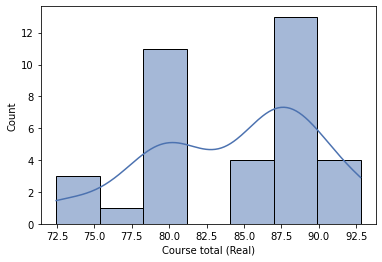

In [5]:
sns.histplot(grades['Course total (Real)'], kde=True)

There are observations are between 72 and 92 approximately. One way to visualise the clusters is by plotting them in a one dimension scatterplot (one dimension because we only ave one feature=the grades).

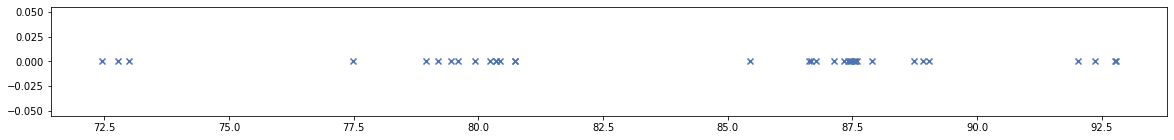

In [6]:
# Plot the grades
plt.figure(figsize=(20,2))
plt.scatter(grades, np.zeros_like(grades), marker='x')

We clearly see 4 clusters in our sample dataset:
* around 72.5 are the lowest grades
* around 80 are the normal grades
* around 87.5 are the good grades
* around 92.5 are the highest grades

We now fit a K-Means algortim with different k's (i.e. number of clusters). The documentation file can be found [at this link](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

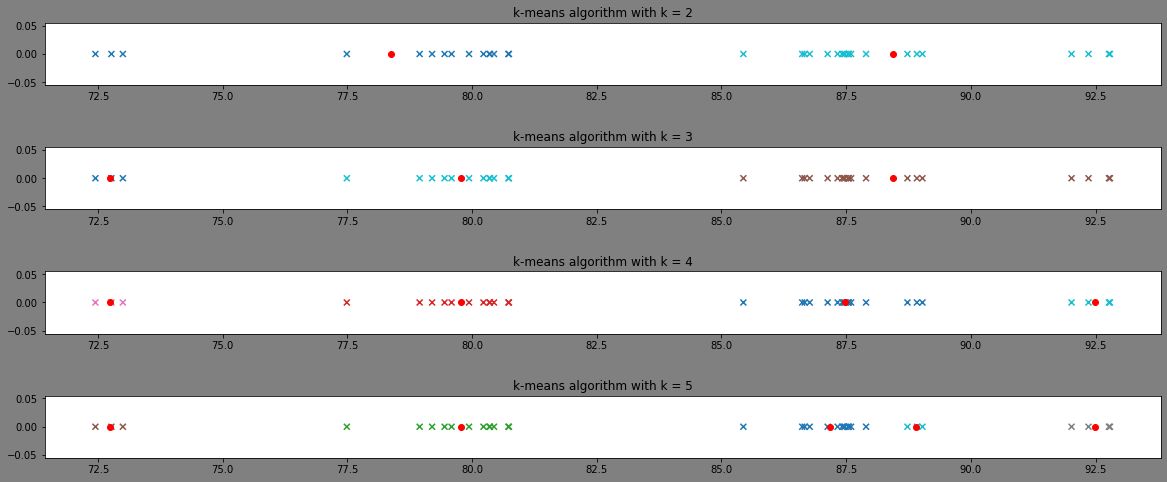

In [7]:
# Fit k-means algorithm for different k
fig, ax = plt.subplots(4, 1, figsize=(20, 8), facecolor="grey")
for k in [2, 3, 4, 5]:
  # Create instance of class
  model = KMeans(n_clusters=k)
  # Fit model
  model.fit(grades)
  # Get centers of clusters
  centers = model.cluster_centers_
  # Get predictions (we use only the grades)
  pred = model.predict(grades)
  # Plot the points, colored by associated cluster
  ax[k-2].scatter(grades, np.zeros_like(grades), marker='x', c=pred, cmap='tab10')
  # Plot the center of each cluster
  ax[k-2].scatter(centers, np.zeros_like(centers), color='red')
  ax[k-2].set_title('k-means algorithm with k = ' + str(k))
plt.subplots_adjust(hspace=1)

With 2 clusters, it already works well. We could then label students as `good` and `not so good` for example.   
However, at least visually, it seems it works best with 4 clusters.  
In order to find out the optimal number of groups, we can plot the the objective/cost function of the algorithm vs the values of `k`. The point where we see an __"elbow"__, i.e, the cost value almost remains the same by further increasing the `k`, could be an appropriate choice for the optimal value of `k`. 

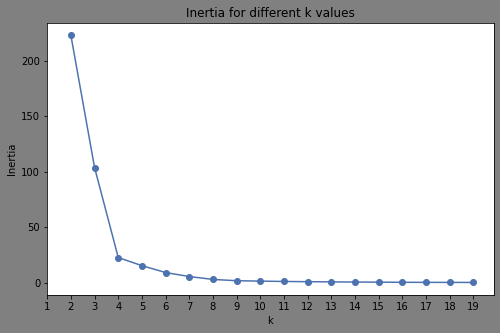

In [8]:
# Elbow Method - inertia
inertia = []
k_values = range(2, 20)
for k in k_values:
  model = KMeans(n_clusters=k)
  model.fit(grades)
  inertia.append(model.inertia_)

# Plot
plt.figure(figsize=(8,5), facecolor="grey")
plt.plot(k_values, inertia, marker='o', linestyle='solid')
plt.title('Inertia for different k values')
plt.ylabel('Inertia')
plt.xlabel('k')
plt.xticks(np.arange(min(k_values)-1, max(k_values)+1, step=1))
plt.show()


In this case, 4 is the optimal number of clusters. The `inertia` is defined as the sum of squared distances of each sample to their closest cluster center. This is the cost function that the algorithm minimizes. From k=5 we see that the reduction in the cost function is much lower than for example for k=1.

### 1.2 Hierarchical clustering
In order to show how it works, we use a small set of 9 points.

In [9]:
# Create Data
data = {
    "p":["p0", "p1", "p2", "p3", "p4", "p5", "p6", "p7", "p8"],
    "x1":[0.84, 0.15, 0.87, 0.90, 0.93, 0.88, 0.87, 0.12, 0.91],
    "x2":[0.91, 0.15, 0.47, 0.54, 0.84, 0.51, 0.86, 0.18, 0.73]}

data = pd.DataFrame(data)
data

,p,x1,x2
0,p0,0.84,0.91
1,p1,0.15,0.15
2,p2,0.87,0.47
3,p3,0.90,0.54
4,p4,0.93,0.84
5,p5,0.88,0.51
6,p6,0.87,0.86
7,p7,0.12,0.18
8,p8,0.91,0.73


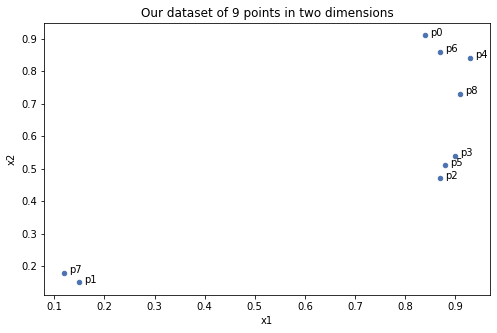

In [10]:
# Plot
data.plot.scatter("x1", "x2", figsize=(8, 5))
plt.title("Our dataset of 9 points in two dimensions")
for point in data.values:
  plt.text(point[1]+0.01, point[2], point[0])

In this case, there are 2 or 3 clusters. We can further compute the euclidean distances between the points.

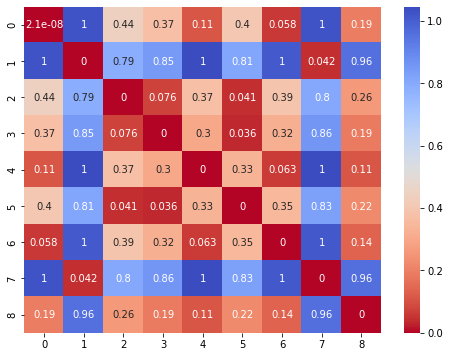

In [11]:
# Show distances
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(pairwise_distances(data[["x1", "x2"]], metric='euclidean')), annot=True, cmap='coolwarm_r', fmt='.2g')

For example `p0` is:
* close to p6, p4, p8 (distance close to 0, here red)
* a little further away from p3, p5, p2
* far from p1, p7 (distance close to 1, here blue)

Now we plot our dendrograms using the [Scipy hierarchical clustering functions](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html).

The first dendrogram uses as a metric the Euclidean distance between observations and the signle method linkage (considers the minimum distance between observations belonging to the clusters).

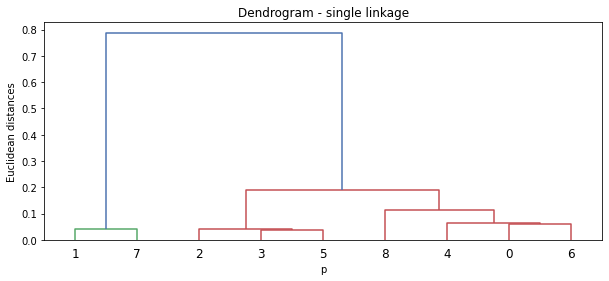

In [12]:
# Plot dendrogram, first with linkage = 'single'
plt.figure(figsize=(10,4))
dendrogram = sch.dendrogram(sch.linkage(data[["x1", "x2"]], method = 'single', metric='euclidean'))
plt.title('Dendrogram - single linkage')
plt.xlabel('p')
plt.ylabel('Euclidean distances')
plt.show()

With `single linkage`, we can see that `p0` is first attached to `p6`, then both of them are attached to `p4`, and finally the these three points are attached to `p8`. This is the first cluster. The resulting number of clusters depends on where we cut the dendrogram, as shown below. With 2 clusters we have: {p1, p7} and {p2, p3, p5, p8, p4, p0, p6} and with 3 clusters we have: {p1, p7}, {p2, p3, p5} and {p8, p4, p0, p6}.

For the second dendrogram we use the `complete` linkage which looks at the maximum distance between observations belonging to the clusters. This forces clusters to be more separated. 

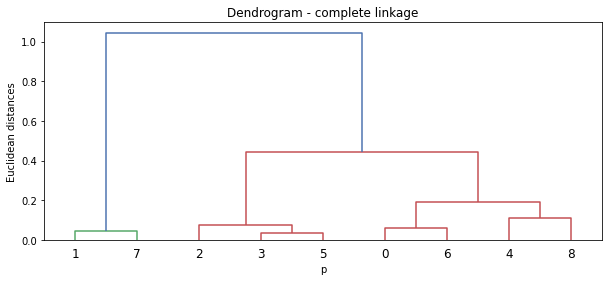

In [13]:
# Plot dendrogram, now with linkage = 'complete'
plt.figure(figsize=(10,4))
dendrogram = sch.dendrogram(sch.linkage(data[["x1", "x2"]], method = 'complete', metric='euclidean'))
plt.title('Dendrogram - complete linkage')
plt.xlabel('p')
plt.ylabel('Euclidean distances')
plt.show()

With `complete linkage`, p0 is first attached to p6 and p4 to p8. Then the two groups are combined to form a superset. This is because p4 and p8 are closer to each other than to the max distance to p0 or p6.

For more documentation on the other linkage methods that you can use with the Scipy functions, you can see the documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html).

From sklearn we can use the [Agglomerative Clustering function](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html), where we can define the number of clusers, the metric to be used for distances and the linkage method as shown below.

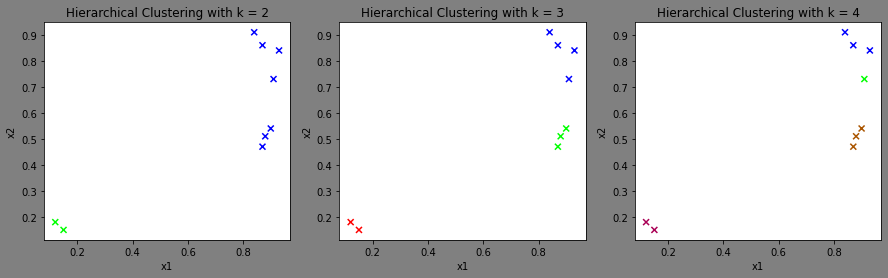

In [14]:
# Plot with different number of clusters
fig, ax = plt.subplots(1,3, figsize=(15,4), facecolor='grey')
for k in [2, 3, 4]:
  clustering = AgglomerativeClustering(n_clusters=k, linkage='single', affinity='euclidean')
  assignment = clustering.fit_predict(data[["x1", "x2"]])
  ax[k-2].scatter(data["x1"], data["x2"], marker='x', c=assignment, cmap='brg')
  ax[k-2].set_title('Hierarchical Clustering with k = ' + str(k))
  ax[k-2].set_xlabel("x1")
  ax[k-2].set_ylabel("x2")
plt.subplots_adjust(hspace=0.3)

We see that k = 2 and k = 3 is fine. However, k = 4 might be overdoing it in this case.

## 2. Runtime complexity comparison exercise


We want to compare the computation time needed between **Kmeans** and **Hierarchial clustering** for different numbers of points.



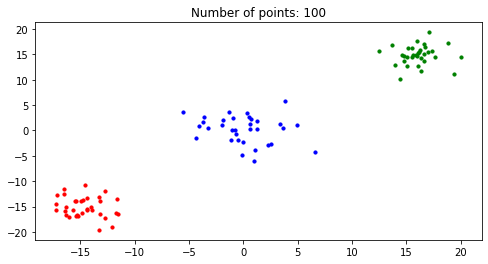

In [15]:
# We create a function that generates 3 clusters
def generate_three_clusters(num_points):
  centers = [(-15, -15), (0, 0), (15, 15)]
  cluster_std = [2, 3, 2]
  X, y = make_blobs(n_samples=num_points, cluster_std=cluster_std, centers=centers, n_features=3, random_state=1)
  return X, y

# Example with 100 points
X, y = generate_three_clusters(100)
# Plot clusters
plt.figure(figsize=(8,4))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", s=10)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", s=10)
plt.scatter(X[y == 2, 0], X[y == 2, 1], color="green", s=10)
plt.title('Number of points: 100')
plt.show()

### 2.1 We generate 3 clusters using the above-defined function for n = 100, 1000, 2500, 5000, 7500, 10000, 25000 points. Store the returned X in a list `X_list`. 




In [16]:
# Define list
X_list = []
# Define numbers of points
num_points = [100, 1000, 2500, 5000, 7500, 10000, 25000]

for n in num_points:
  # Generate three clusters
  X, y = generate_three_clusters(n)

  # Append X to X_list
  X_list.append(X)

In [17]:
X_list[0].shape

(100, 2)

### 2.2 For all samples of points, fit a k-means algorithm and a hierarchical clustering algorithm and record to completion time. Use [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) with a number of clusters equal to 3. In order to record the time, use the `time` package as shown below.

In [18]:
# Example with the time package
import time
start = time.time()
for i in range(10000000):
  a = 1 + 1 # do something
end = time.time()
print('Start: ' + str(start))
print('End: ' + str(end))
print('Time: ' + str(end-start))

Start: 1670856241.38968
End: 1670856242.1058922
Time: 0.716212272644043


In [19]:
# Record time in list
k_means_time = []
hc_time = []

for X in X_list:

  # Create instance of KMeans class (with 3 clusters)
  model = KMeans(n_clusters=3)

  # Fit the model on X and record the time to fit
  start = time.time()
  model.fit(X)
  end = time.time()

  # Store the execution time in k_means_time
  k_means_time.append(end-start)

  # Create instance of AgglomerativeClustering class (with 3 clusters)
  model = AgglomerativeClustering(n_clusters=3)

  # Fit the model on X and record the time to fit
  start = time.time()
  model.fit(X)
  end = time.time()

  # Store the execution time in hc_time
  hc_time.append(end-start)

### 2.3 Plot the execution time vs. number of points for k-means and hierarchical clustering

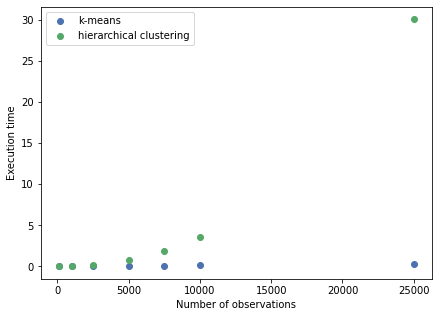

In [20]:
plt.figure(figsize=(7,5))
plt.scatter(num_points, k_means_time, label='k-means')
plt.scatter(num_points, hc_time, label='hierarchical clustering')
plt.ylabel('Execution time')
plt.xlabel('Number of observations')
plt.legend()
plt.show()

## 3. Customer segmentation
We now implement customer segmentation with the two algorithms. The data set can be found in Kaggle [here](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

### 3.1 Load, prepare, and explore data

In [21]:
df = pd.read_csv('https://raw.githubusercontent.com/michalis0/DataMining_and_MachineLearning/master/week13/data/Mall_Customers.csv', index_col=0)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


We have 200 customers with their gender, age, annual income, and spending score.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [23]:
# Convert Gender to numerical
df.Gender = df.Gender.astype('category').cat.codes
df.Gender.value_counts()

0    112
1     88
Name: Gender, dtype: int64

In this case 0 corresponds to female customers.

In [24]:
df.describe()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,0.440000,38.850000,60.560000,50.200000
std,0.497633,13.969007,26.264721,25.823522
min,0.000000,18.000000,15.000000,1.000000
25%,0.000000,28.750000,41.500000,34.750000
50%,0.000000,36.000000,61.500000,50.000000
75%,1.000000,49.000000,78.000000,73.000000
max,1.000000,70.000000,137.000000,99.000000


In [25]:
df.isnull().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

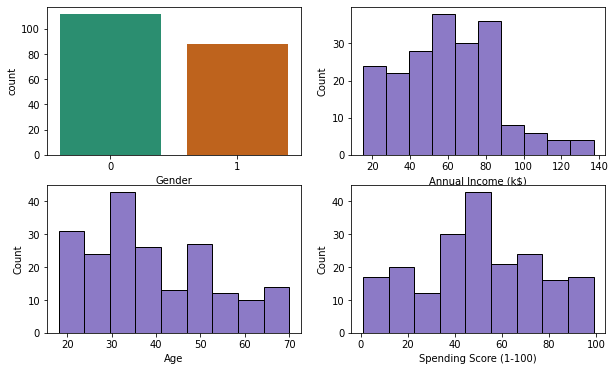

In [26]:
# Univariate Analysis
fig, ax = plt.subplots(2, 2, figsize=(10,6))
i = 0
j = 0
for var in df:
  if var == "Gender":
    sns.countplot(x=df[var], ax=ax[i, j], palette='Dark2')
  else:
    sns.histplot(df[var], ax=ax[i, j], color=(0.4, 0.3, 0.7))
  i += 1
  if i == 2:
    i = 0
    j += 1
plt.show()

<Figure size 720x432 with 0 Axes>

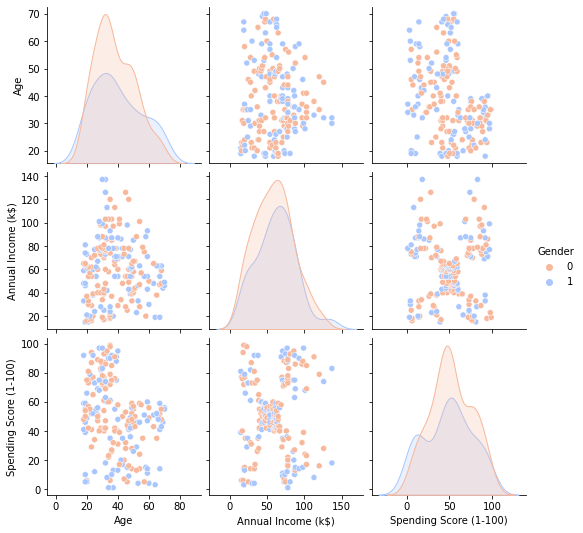

In [27]:
# Bivariate Analysis
plt.figure(figsize=(10,6))
sns.pairplot(df, hue='Gender', palette="coolwarm_r")

Using `Annual Income` and `Spending Score`, we can observe 5 clusters.

### 3.2 k-means algorithm
Again, we first want to find out the good number of clusters.

In [28]:
# Function to plot inertia
def k_means_inertia_plot(variables):

  # Create new dataframe
  new_df = df[variables]

  # Fit k-means algorithm for different k
  inertia = []
  k_values = range(2, 20)
  for k in k_values:
    model = KMeans(n_clusters=k)
    model.fit(new_df)
    inertia.append(model.inertia_)

  # Plot
  plt.figure(figsize=(10,6))
  plt.plot(k_values, inertia, marker='o', linestyle='solid')
  plt.title('Inertia for different k values')
  plt.ylabel('Inertia')
  plt.xlabel('k')
  plt.xticks(np.arange(min(k_values)-1, max(k_values)+1, step=1))
  plt.show()

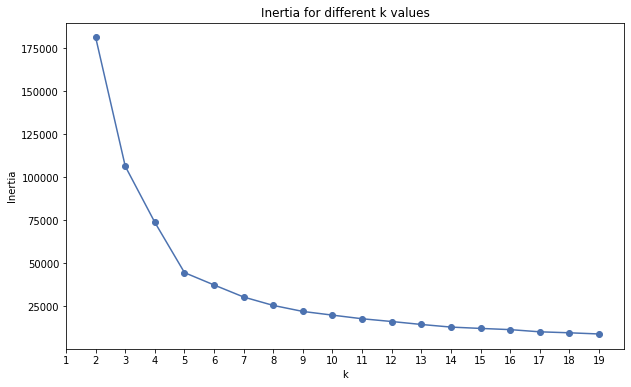

In [29]:
# Use function - two variables
k_means_inertia_plot(["Annual Income (k$)", "Spending Score (1-100)"])

This confirms what we saw in the EDA. Using these two variables, 5 clusters are optimal.

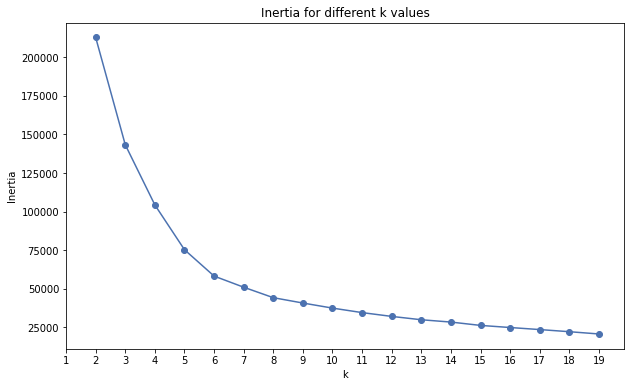

In [30]:
# Use function - three variables
k_means_inertia_plot(["Annual Income (k$)", "Spending Score (1-100)", "Age"])

With three variables, this is less clear. Maybe 6 clusters would be great.

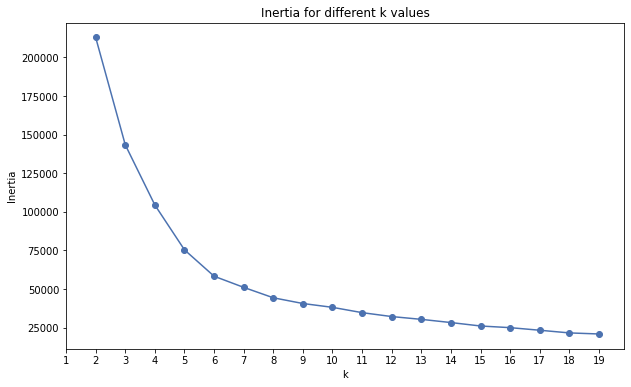

In [31]:
# Use function - four variables
k_means_inertia_plot(["Annual Income (k$)", "Spending Score (1-100)", "Age", "Gender"])

Again, not clear with all four variables. Maybe 6 clusters would be good.

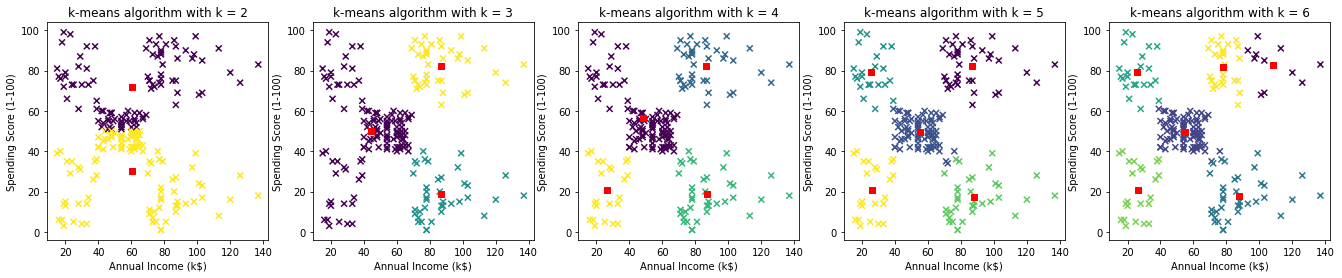

In [32]:
# Plot clusters for k = 2,3,4,5,6 and two variables
new_df = df[['Annual Income (k$)', 'Spending Score (1-100)']]

fig, ax = plt.subplots(1,5, figsize=(23,4))
for k in [2, 3, 4, 5, 6]:
  model = KMeans(n_clusters=k)
  model.fit(new_df)
  centers = model.cluster_centers_
  pred = model.predict(new_df)
  ax[k-2].scatter(new_df['Annual Income (k$)'], new_df['Spending Score (1-100)'], marker='x', c=pred)
  for c in range(k):
    ax[k-2].scatter(centers[c][0], centers[c][1], color='red', marker=',')
  ax[k-2].set_title('k-means algorithm with k = ' + str(k))
  ax[k-2].set_xlabel("Annual Income (k$)")
  ax[k-2].set_ylabel("Spending Score (1-100)")

As already mentioned, the optimal number of cluster is 5 in this case. Once clustering is done, we may then use the result to label (i.e. classifiy) the customers, for example:
* Customers who earn little and spend little (the `reasonable poor`)
* Customers who earn little and spend a lot (the `senseless poor`)
* Customers who earn average and spend average (the `middle-income`)
* Customers who earn a lot and spend a lot (the `rich`). The marketing effort should focus mainly on them.
* Customers who earn a lot and spend little (the `stingy`).

With three variables and 6 clusters: [link](https://www.kaggle.com/kushal1996/customer-segmentation-k-means-analysis)

In [33]:
pd.Series(pred).value_counts()

1    80
2    36
5    28
4    23
3    22
0    11
dtype: int64

In [34]:
centers

array([[108.18181818,  82.72727273],
       [ 55.0875    ,  49.7125    ],
       [ 87.75      ,  17.58333333],
       [ 25.72727273,  79.36363636],
       [ 26.30434783,  20.91304348],
       [ 78.03571429,  81.89285714]])

We can see that the first cluster center corresponds to the middle income group of 80 consumers, the biggest cluster in our example.

### 3.3 Hierarchical clustering
We now do the same with hierarchical clustering. This yields similar results.

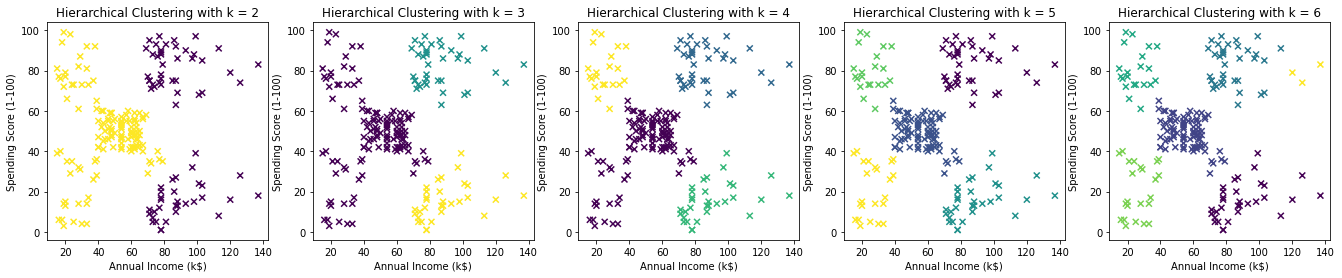

In [35]:
# Plot with different k and two variables
fig, ax = plt.subplots(1,5, figsize=(23,4))
for k in [2, 3, 4, 5, 6]:
  clustering = AgglomerativeClustering(n_clusters=k, linkage='complete', affinity='euclidean')
  assignment = clustering.fit_predict(new_df)
  ax[k-2].scatter(new_df['Annual Income (k$)'], new_df['Spending Score (1-100)'], marker='x', c=assignment)
  ax[k-2].set_title('Hierarchical Clustering with k = ' + str(k))
  ax[k-2].set_xlabel("Annual Income (k$)")
  ax[k-2].set_ylabel("Spending Score (1-100)")

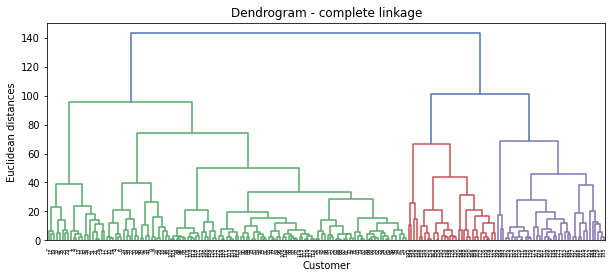

In [36]:
# Plot dendrogram - complete
plt.figure(figsize=(10,4))
dendrogram = sch.dendrogram(sch.linkage(new_df, method = 'complete'))
plt.title('Dendrogram - complete linkage')
plt.xlabel('Customer')
plt.ylabel('Euclidean distances')
plt.show()

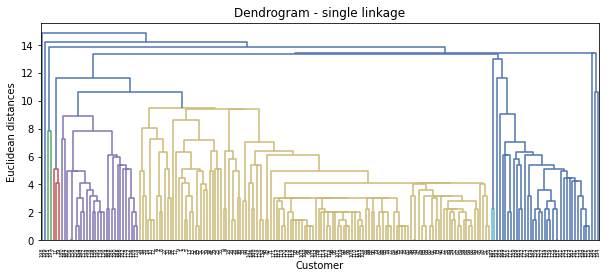

In [37]:
# Plot dendrogram - single
plt.figure(figsize=(10,4))
dendrogram = sch.dendrogram(sch.linkage(new_df, method = 'single'))
plt.title('Dendrogram - single linkage')
plt.xlabel('Customer')
plt.ylabel('Euclidean distances')
plt.show()

It does not work with single linkage. With complete linkage, we can see the 5 clusters on the dendrogram.

## 4. Clustering vs. classification
We compare classification and clustering algortihms, using a labelled data set of emails.

### 4.1 Load data

In [39]:
emails = pd.read_csv('https://raw.githubusercontent.com/michalis0/DataMining_and_MachineLearning/master/week13/data/spambase.csv')
emails.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


We see the emails were already vectorised and we have 57 features and a `class` feature, which classifies email into SPAM or NOT SPAM (2 classes).

In [40]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

In [41]:
# Base rate simplified version
print(emails["class"].value_counts())
len(emails[emails["class"] == 0]) / len(emails)

0    2788
1    1813
Name: class, dtype: int64


0.6059552271245382

### 4.2 Algorithms comparison: k-means vs. logistic regression



In [42]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

# Select variables
X = emails.drop("class", axis = 1)
y = emails["class"]

# k-means
kmeans = KMeans(n_clusters=2)  # because we have two classes

# Logistic regression
logit = LogisticRegression()

algorithms = [kmeans, logit]

for algo in algorithms:

  # K-fold cross validation
  kf = KFold(n_splits=10, shuffle=True, random_state=42)

  # Conduct k-fold cross-validation
  cv_results = cross_val_score(algo, # Algorithm
                             X, # Feature matrix
                             y, # Target vector
                             cv=kf, # Performance metric
                             scoring="accuracy", # Loss function
                             n_jobs=-1) # Use all CPU cores

  # Print mean
  print (f"The Mean Score is {cv_results.mean():.2f} for {algo}")

The Mean Score is 0.60 for KMeans(n_clusters=2)
The Mean Score is 0.92 for LogisticRegression()


Conclusion: In general, classification algorithms are more precise than clustering for classification problems. This means as soon as you have labelled data, you should use classification. When there are no label or if you want to label unlabelled data, you can use clustering.

## References
* https://www.kaggle.com/kushal1996/customer-segmentation-k-means-analysis
* https://www.kaggle.com/morecoding/hierarchical-clustering